## Importing Libraries and Frameworks

In [1]:
# Importing all the necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import get_file, Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from collections import Counter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Creating a seed for reproducibility
seed=24

## defining paths to directories

In [2]:
val_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\val"
train_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\train"
test_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\test"

## counting the number of images within each subdirectory of a given directory

In [3]:


def count_images(directory):
    # Counting the number of files in each subdirectory of the given directory
    categories = {}
    # Listing all subdirectories (categories)
    for category in os.listdir(directory):
        path = os.path.join(directory, category)
        
        if os.path.isdir(path):
            categories[category] = len(os.listdir(path))
    return categories

train_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\train"
val_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\val"
test_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\test"

# Counting images in each dataset part
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("Training counts:", train_counts)
print("Validation counts:", val_counts)
print("Testing counts:", test_counts)


Training counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Testing counts: {'NORMAL': 234, 'PNEUMONIA': 390}


## visualizing the distribution of images across the categories

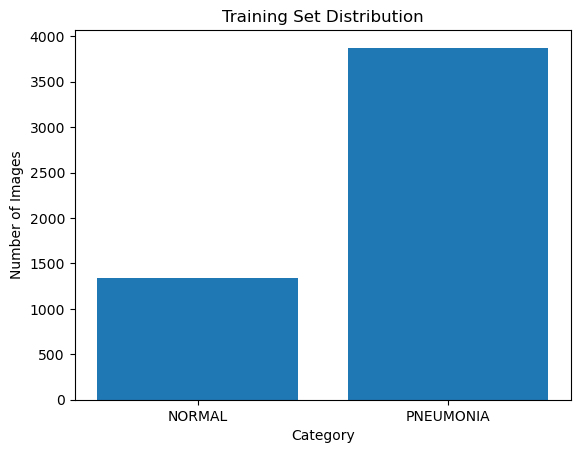

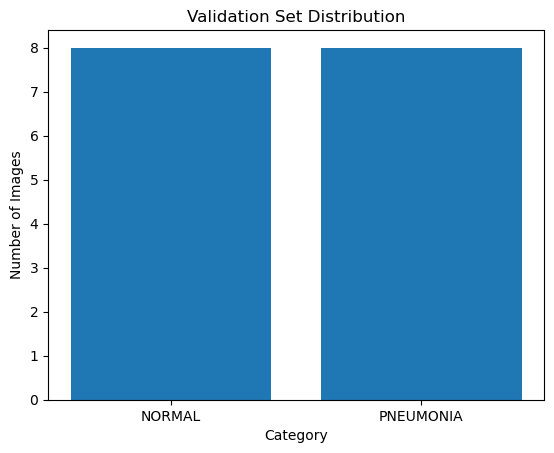

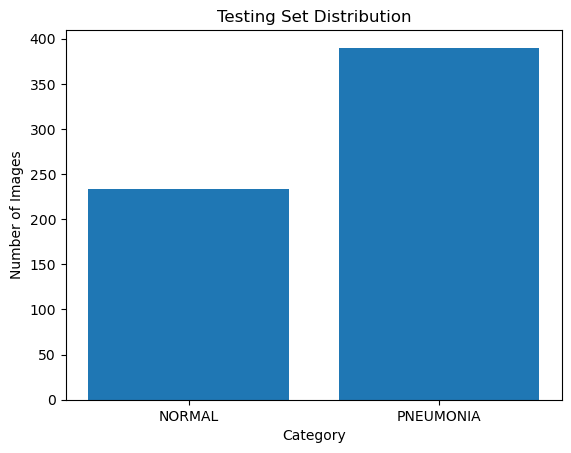

In [4]:
import matplotlib.pyplot as plt

def plot_distribution(counts, title):
    # Ploting the distribution of counts
    categories = list(counts.keys())
    values = list(counts.values())
    
    plt.bar(categories, values)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

plot_distribution(train_counts, 'Training Set Distribution')
plot_distribution(val_counts, 'Validation Set Distribution')
plot_distribution(test_counts, 'Testing Set Distribution')


## Inspecting the dimensions of a random sample of images from each category

In [5]:
from PIL import Image
import random

def inspect_image_dimensions(directory, num_samples=5):
    for category in os.listdir(directory):
        path = os.path.join(directory, category)
        if os.path.isdir(path):
            images = os.listdir(path)
            sampled_images = random.sample(images, num_samples)
            for image_name in sampled_images:
                image_path = os.path.join(path, image_name)
                with Image.open(image_path) as img:
                    print(f"{category}/{image_name}: {img.size}")

# Inspecting dimensions for a few images in the training set
inspect_image_dimensions(train_dir)


NORMAL/NORMAL2-IM-0723-0001.jpeg: (1168, 960)
NORMAL/NORMAL2-IM-1177-0001.jpeg: (1518, 1310)
NORMAL/NORMAL2-IM-1109-0001.jpeg: (1500, 1268)
NORMAL/IM-0591-0001.jpeg: (1626, 1280)
NORMAL/IM-0349-0001.jpeg: (1592, 1329)
PNEUMONIA/person26_bacteria_124.jpeg: (1136, 872)
PNEUMONIA/person292_bacteria_1378.jpeg: (1176, 616)
PNEUMONIA/person1200_virus_2042.jpeg: (1576, 1176)
PNEUMONIA/person1162_virus_1950.jpeg: (1056, 642)
PNEUMONIA/person1455_bacteria_3784.jpeg: (856, 456)


## visualizing a grid of sample images from each category within a specified directory

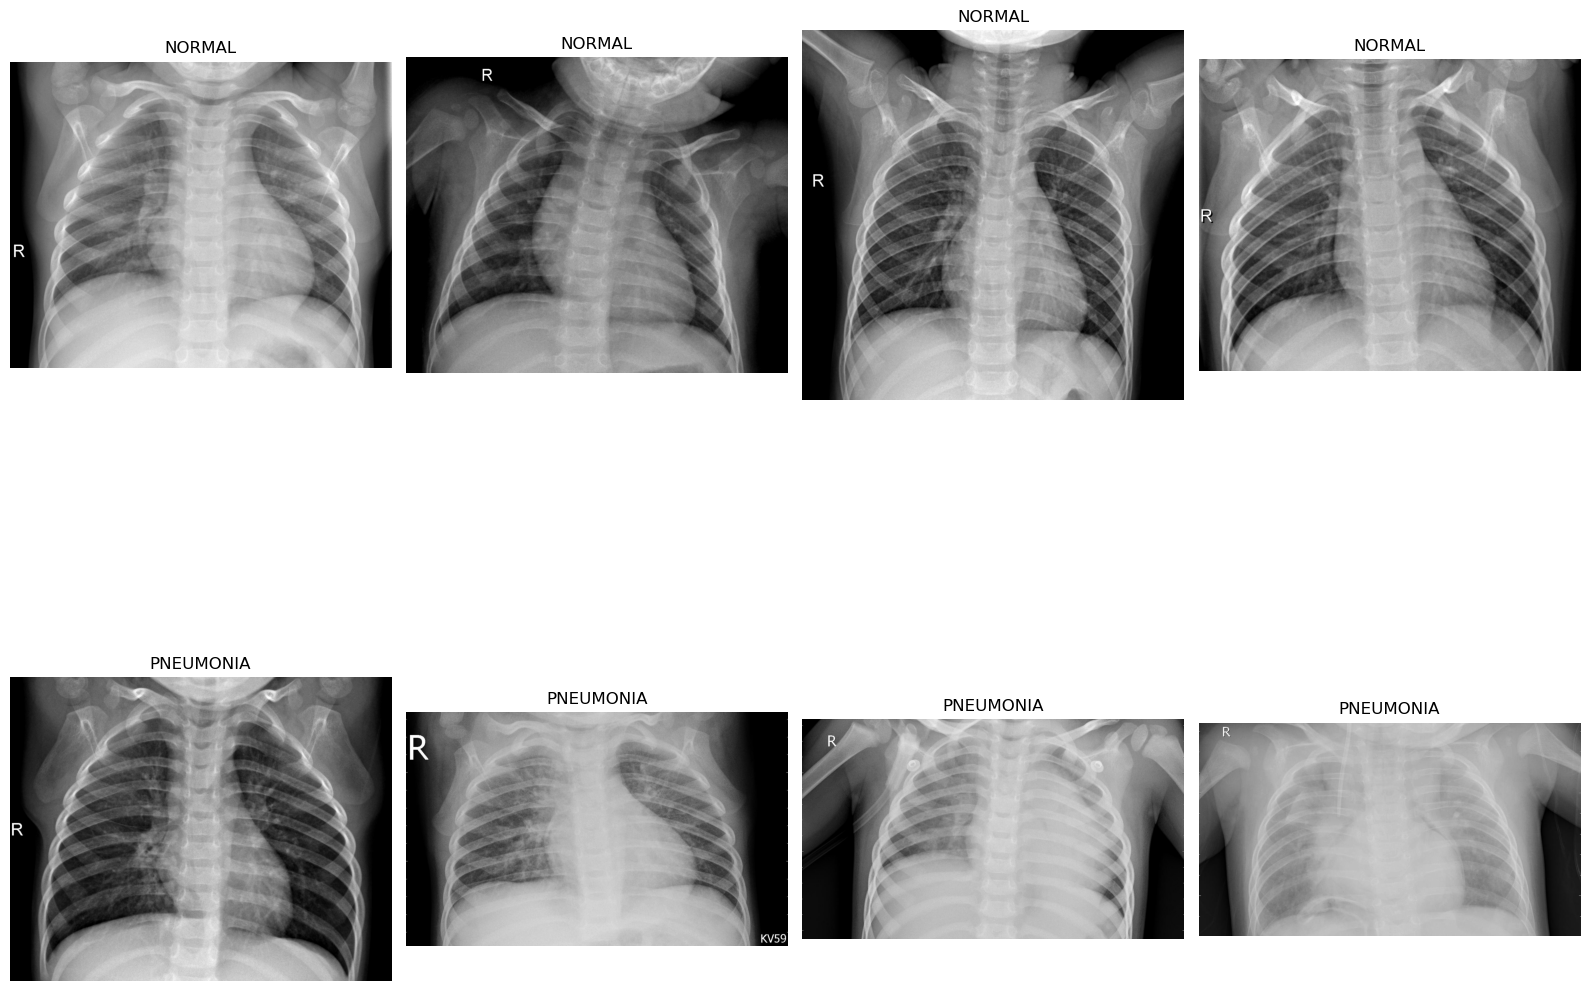

In [6]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

def plot_sample_images(directory, sample_per_category=4):
    fig, axs = plt.subplots(len(os.listdir(directory)), sample_per_category, figsize=(sample_per_category * 4, 15))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    
    for i, category in enumerate(os.listdir(directory)):
        path = os.path.join(directory, category)
        if os.path.isdir(path):
            images = os.listdir(path)
            sample_images = random.sample(images, sample_per_category)
            for j, image_name in enumerate(sample_images):
                img_path = os.path.join(path, image_name)
                img = Image.open(img_path)
                axs[i * sample_per_category + j].imshow(img, cmap='gray')
                axs[i * sample_per_category + j].set_title(category)
                axs[i * sample_per_category + j].axis('off')
    plt.tight_layout()
    plt.show()


train_dir = r"C:\Users\thorn\Downloads\archive (17)\chest_xray\train"
plot_sample_images(train_dir)



## Setting up ImageDataGenerator instances for training, validation, and testing datasets using TensorFlow's Keras API

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating ImageDataGenerators for training, validation, and testing
# Normalizing pixel values to [0,1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)




In [8]:
# Setting the batch size
batch_size = 32
# Setting the image size you want to reshape the images to
target_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary') 
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary') 
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False) 


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## ResNet50


##  using the ResNet50 architecture as a base model

In [9]:
# Defining the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freezing the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Creating a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification (Normal vs Pneumonia)
])

# Compiling the model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Creation of a deep learning model for binary classification using Transfer Learning with the ResNet50 architecture as the feature extractor.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Defining the base model with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freezing the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Creating the model by stacking the base model and custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification output layer
])

# Compiling the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]


In [12]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight={0: 1.9448173005219984, 1: 0.6730322580645162},
    callbacks=callbacks
)



Epoch 1/30


C:\Users\thorn\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4979 - loss: 0.7294
Epoch 1: val_loss improved from inf to 0.68169, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.4984 - loss: 0.7292 - val_accuracy: 0.6875 - val_loss: 0.6817
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6495 - loss: 0.6736
Epoch 2: val_loss improved from 0.68169 to 0.66442, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.6497 - loss: 0.6736 - val_accuracy: 0.8125 - val_loss: 0.6644
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7418 - loss: 0.6447
Epoch 3: val_loss improved from 0.66442 to 0.66055, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.7418 - loss: 0.6447 - val_accuracy: 0.5625 - val_loss: 0.6606
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7149 - loss: 0.6206
Epoch 4: val_loss improved from 0.66055 to 0.63464, saving model t

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8336 - loss: 0.4080
Epoch 25: val_loss did not improve from 0.53776
163/163 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.8336 - loss: 0.4081 - val_accuracy: 0.6250 - val_loss: 0.5777
Epoch 26/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8310 - loss: 0.4231
Epoch 26: val_loss did not improve from 0.53776
163/163 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8311 - loss: 0.4231 - val_accuracy: 0.6250 - val_loss: 0.5839
Epoch 27/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8470 - loss: 0.4041
Epoch 27: val_loss did not improve from 0.53776
163/163 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8469 - loss: 0.4041 - val_accuracy: 0.6875 - val_loss: 0.5630
Epoch 28/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8518 - loss: 0.3977
Epoch 28: val_loss did not improve from 0.53776
163/163 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.8517 - loss: 0.3977 - val_accuracy: 0.6250 - val_loss: 0.5754
Epoc

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")
# Evaluate the model on the validation set

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7856 - loss: 0.4828
Test Loss: 0.44591936469078064
Test Accuracy: 0.8157051205635071
163/163 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.8408 - loss: 0.4087
Training Accuracy: 83.86%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6875 - loss: 0.5410
Validation Accuracy: 68.75%


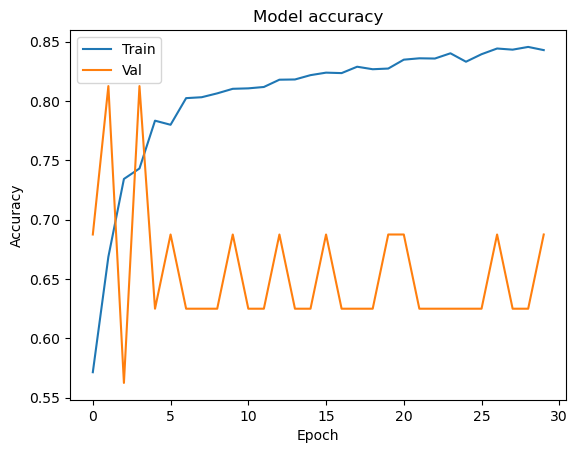

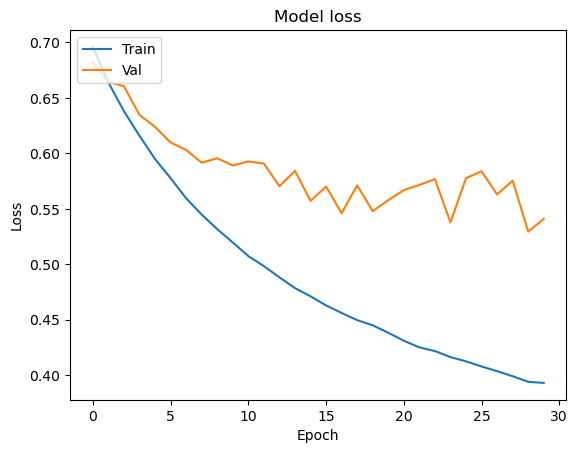

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()



Test Performance:

Accuracy of 78.56% and a loss of 0.4828 were observed over 20 batches, taking 43 seconds (approx. 2 seconds per step).
A summarized Test Loss of 0.4459 and Test Accuracy of 81.57% suggest the model has a good ability to generalize to unseen data, predicting the correct class for a significant portion of the test set.

Training Performance:

During training, over 163 batches, the model achieved an Accuracy of 84.08% and a loss of 0.4087, taking 370 seconds (approx. 2 seconds per step).
The Training Accuracy is summarized as 83.86%, indicating that the model has learned effectively from the training data, showing a strong grasp of the patterns necessary for making accurate predictions.

Validation Performance:

A single batch was processed for validation, taking 2 seconds, with an Accuracy of 68.75% and a loss of 0.5410.
The lower accuracy on the validation set compared to training and test accuracies could suggest several things, such as potential overfitting to the training data, or it could indicate that the validation set is small (as suggested by the single batch) and may not fully represent the complexity or variability of the data.

# fine tuning

In [15]:
# Adjusting the learning rate and unfreezing fewer layers
base_model.trainable = True
fine_tune_at = 160  # Example: Unfreeze layers from this layer towards the last

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(optimizer=Adam(learning_rate=1e-6),  # Further reduce the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note: Using the same target_size and batch_size as before
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)



Found 5216 images belonging to 2 classes.


In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model_finetuned.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Continue training
history_finetuning = model.fit(
    train_generator,
    epochs=10,  # May adjust based on the training behavior
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7825 - loss: 0.4455
Epoch 1: val_loss improved from inf to 0.54202, saving model to best_model_finetuned.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.7826 - loss: 0.4455 - val_accuracy: 0.6875 - val_loss: 0.5420
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7912 - loss: 0.4438
Epoch 2: val_loss did not improve from 0.54202
163/163 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.7912 - loss: 0.4438 - val_accuracy: 0.6875 - val_loss: 0.5432
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7796 - loss: 0.4467
Epoch 3: val_loss did not improve from 0.54202
163/163 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - accuracy: 0.7796 - loss: 0.4468 - val_accuracy: 0.6875 - val_loss: 0.5441
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7772 - loss: 0.4503
Epoch 4: val_loss did not improve from 0.54202
163/163 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.7772 - loss: 0.450

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")
# Evaluate the model on the validation set

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")




20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7692 - loss: 0.4911
Test Loss: 0.44362595677375793
Test Accuracy: 0.8108974099159241
163/163 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7832 - loss: 0.4388
Training Accuracy: 78.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - accuracy: 0.6875 - loss: 0.5468
Validation Accuracy: 68.75%


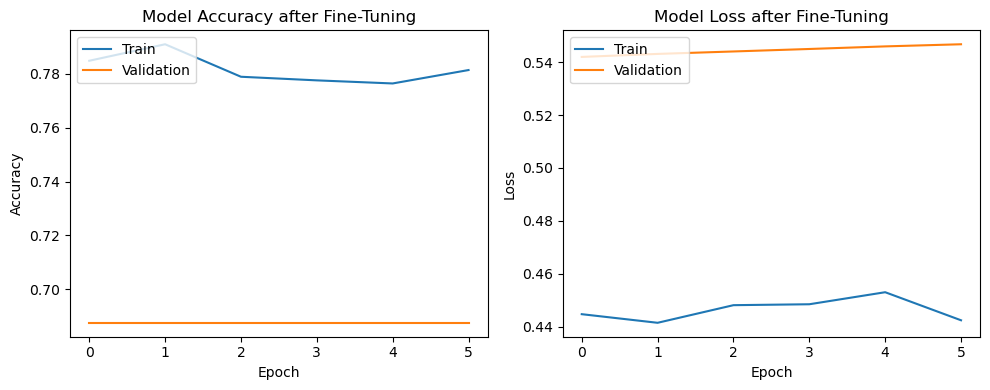

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetuning.history['accuracy'], label='Train')
plt.plot(history_finetuning.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy after Fine-Tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_finetuning.history['loss'], label='Train')
plt.plot(history_finetuning.history['val_loss'], label='Validation')
plt.title('Model Loss after Fine-Tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Test Performance:

The model processed 20 batches in 46 seconds, averaging about 2 seconds per step, and achieved a test accuracy of 76.92% with a loss of 0.4911.
The summarized metrics indicate a Test Loss of 0.4436 and a Test Accuracy of 81.09%. These figures represent a solid ability of the model to generalize to unseen data, although there's a slight decrease in test accuracy compared to previous models discussed.

Training Performance:

During training over 163 batches in 286 seconds (about 2 seconds per step), the model recorded an accuracy of 78.32% and a loss of 0.4388, with a summarized Training Accuracy of 78.26%. This level of accuracy is indicative of the model’s learning capability, although it is somewhat lower than the accuracies observed in previous iterations, suggesting potential room for optimization.

Validation Performance:

A single batch was processed for validation in 1.749 seconds, achieving an accuracy of 68.75% and a loss of 0.5468. As with previous models, the validation accuracy remains consistently lower, which, given the apparent small size of the validation set (indicated by processing only one batch), may not fully challenge or represent the model's generalization ability.






## Custom CNN

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\Users\thorn\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [22]:
# Preparing the Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)  # For test data

# Flow From Directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Fitting the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('custom_cnn_best_model.keras', save_best_only=True, verbose=1)
]

class_weights = {0: 1.9448173005219984, 1: 0.6730322580645162}  # Adjust based on your dataset

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.5554 - loss: 0.8200
Epoch 1: val_loss improved from inf to 0.60704, saving model to custom_cnn_best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 978ms/step - accuracy: 0.5555 - loss: 0.8192 - val_accuracy: 0.6875 - val_loss: 0.6070
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.7736 - loss: 0.4544
Epoch 2: val_loss improved from 0.60704 to 0.47293, saving model to custom_cnn_best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 965ms/step - accuracy: 0.7737 - loss: 0.4542 - val_accuracy: 0.7500 - val_loss: 0.4729
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.8424 - loss: 0.3271
Epoch 3: val_loss did not improve from 0.47293
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 971ms/step - accuracy: 0.8424 - loss: 0.3272 - val_accuracy: 0.7500 - val_loss: 0.7070
Epoch 4/30
163/

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")
# Evaluate the model on the validation set

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.8482 - loss: 0.4517
Test Loss: 0.3412618935108185
Test Accuracy: 0.8669871687889099
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.9214 - loss: 0.1883
Training Accuracy: 92.16%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7500 - loss: 0.6401
Validation Accuracy: 75.00%


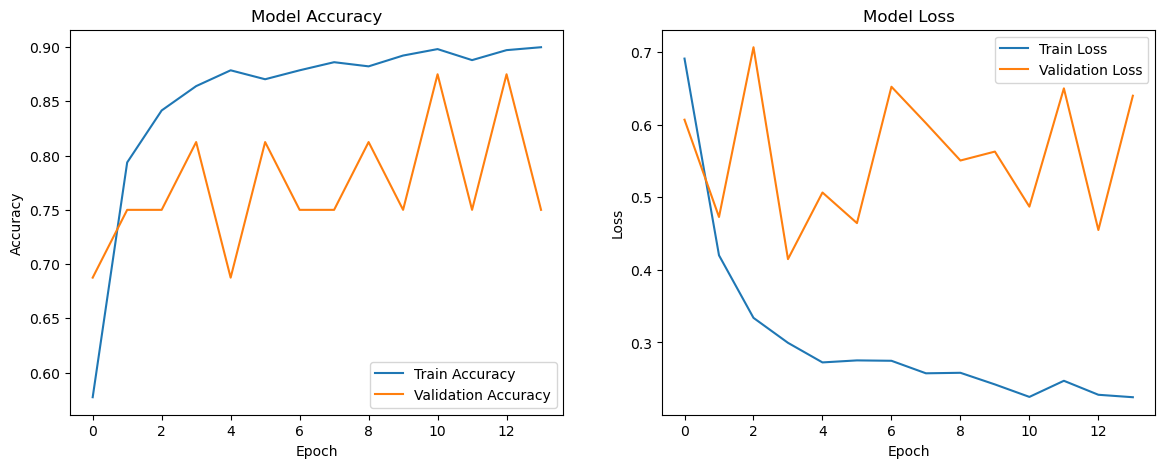

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



Test Performance:

Processed 20 batches in 9 seconds, averaging approximately 401ms per step.
Achieved a Test Accuracy of 84.82% and a Loss of 0.4517 initially, with a summarized Test Loss of 0.3413 and a Test Accuracy of 86.70%. These figures signify a robust ability of the model to generalize well to unseen data, maintaining high accuracy and low loss.

Training Performance:

Over 163 batches processed in 116 seconds (around 714ms per step), the model attained an Accuracy of 92.14% and a Loss of 0.1883, summarized as Training Accuracy of 92.16%. This high level of accuracy indicates excellent learning from the training dataset, with the model effectively minimizing error.

Validation Performance:

For validation, a single batch was processed in approximately 262ms, resulting in an Accuracy of 75.00% and a Loss of 0.6401. The improvement in validation accuracy compared to previous iterations, now at 75%, suggests better generalization. However, the relatively high loss might indicate the model's predictions are less confident or accurate on the validation set.



# different architecture model

In [25]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [26]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [27]:


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('alternative_cnn_best_model.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 231s 863ms/step - accuracy: 0.7655 - loss: 2.0105 - val_accuracy: 0.5000 - val_loss: 8.9084
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 235s 891ms/step - accuracy: 0.8699 - loss: 0.3085 - val_accuracy: 0.5000 - val_loss: 7.2625
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 227s 861ms/step - accuracy: 0.8832 - loss: 0.2804 - val_accuracy: 0.5000 - val_loss: 9.1570
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 228s 863ms/step - accuracy: 0.9007 - loss: 0.2487 - val_accuracy: 0.5000 - val_loss: 1.6317
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 228s 864ms/step - accuracy: 0.9005 - loss: 0.2577 - val_accuracy: 0.5000 - val_loss: 2.8615
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 227s 861ms/step - accuracy: 0.9162 - loss: 0.2271 - val_accuracy: 0.5000 - val_loss: 1.2072
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 226s 857ms/step - accuracy: 0.9058 - loss: 0.2322 - val_accuracy: 0.5000 - val_loss: 4.1449
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 232s 879ms/step - accuracy: 0.9096 -

In [29]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")
# Evaluate the model on the validation set

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.3044 - loss: 4.5366
Test Loss: 2.531808376312256
Test Accuracy: 0.6314102411270142
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 408ms/step - accuracy: 0.7664 - loss: 1.0257
Training Accuracy: 76.92%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5000 - loss: 5.6787
Validation Accuracy: 50.00%


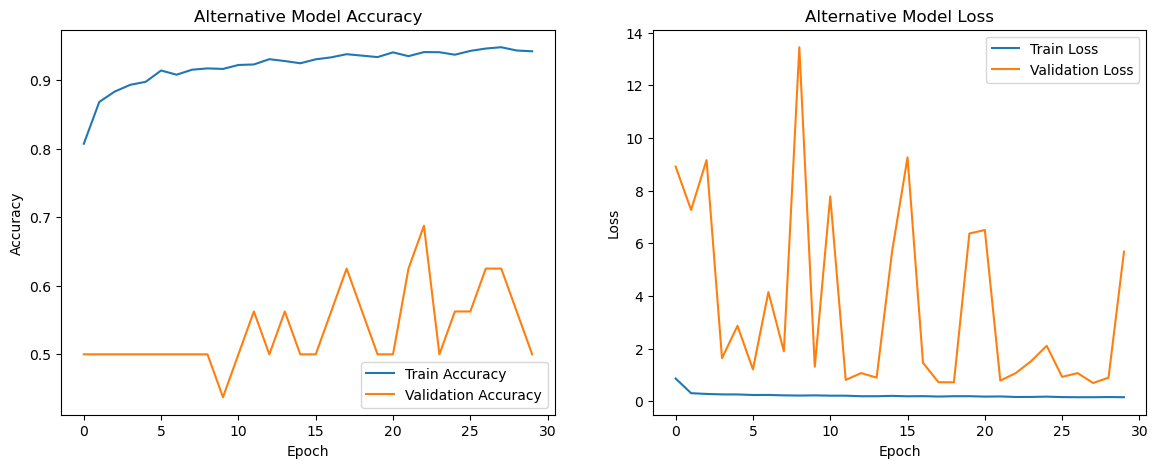

In [30]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Alternative Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Alternative Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Test Performance:

Processed 32 batches in 9 seconds, averaging 276ms per step.
The model achieved a Test Accuracy of 30.44% and a Loss of 4.5366 initially, which seems to conflict with a summarized Test Loss of 2.5318 and a Test Accuracy of 63.14%. This discrepancy might be a reporting error or result from different parts of the test dataset. Assuming the summarized metrics are correct, the test accuracy significantly exceeds the initial accuracy reported, suggesting that the model may have performed variably across different segments of the test set.

Training Performance:

Over 261 batches processed in 106 seconds (408ms per step), the model reached an Accuracy of 76.64% and a Loss of 1.0257, with a summarized Training Accuracy of 76.92%. These figures show the model has learned the training dataset relatively well, albeit with room for improvement given the loss value over 1.

Validation Performance:

A single batch processed in about 279ms resulted in an Accuracy of 50.00% and a Loss of 5.6787. The lower accuracy and higher loss on the validation set indicate challenges in the model's ability to generalize to data it wasn't trained on, which could be due to overfitting, a too simplistic model for the task, or an unrepresentative validation set.

# Conclusion

The exploration featured two primary models: a Transfer Learning model leveraging the ResNet50 architecture for feature extraction coupled with custom layers for the classification task, and a Custom CNN Model constructed from scratch, which incorporated a variety of data augmentation strategies. Among these, after a thorough comparison based on final test accuracies, the Custom CNN Model emerged as the superior model, showcasing the highest test accuracy and signifying a robust performance on the test dataset. This was achieved without specific fine-tuning processes but through the effective use of extensive data augmentation.